# CreditRisk: Loan Default Prediction 

---

## Overview  
This project involves the development of a credit scoring model designed to predict the probability that a customer will default on a loan. The primary objective is to build a robust and interpretable machine learning system that classifies loan applications as either approved or denied based on the likelihood of repayment. Such a tool is essential for mitigating financial risk and optimizing decision-making in the credit approval process.

---

## Context  
Organizations in the financial sector often face challenges in assessing the creditworthiness of clients, particularly those with limited or no credit history. By leveraging advanced machine learning techniques and diverse data sources (such as behavioral and transactional data), this project aims to provide a data-driven solution to predict loan default risks. Transparency and interpretability are key components of this system to ensure trust and usability for both internal stakeholders and end-users.

---

## Objectives  
The project is divided into multiple phases to ensure a structured and comprehensive approach:

1. **Data Preparation**:
   - Cleaning and preprocessing data, including feature engineering and normalization.
   - Addressing class imbalances to enhance model performance.

2. **Model Development**:
   - Testing and evaluating multiple machine learning models (Logistic Regression, Random Forest, LightGBM).
   - Selecting the best-performing model based on metrics such as AUC (Area Under the ROC Curve).

3. **Optimization**:
   - Implementing a business-specific cost function to minimize financial losses, particularly focusing on reducing false negatives.
   - Hyperparameter optimization using advanced techniques (e.g., Bayesian optimization via HyperOpt).

4. **Interpretability**:
   - Leveraging SHAP (SHapley Additive exPlanations) to provide global and local feature importance, ensuring the model’s predictions are explainable and trustworthy.

5. **Deployment**:
   - Creating an interactive dashboard to visualize predictions, model explanations, and insights, enabling end-users to make informed decisions.

---

## Methodology  
This project follows a data science lifecycle that includes:

- **Exploratory Data Analysis (EDA)**: Understanding the dataset, detecting anomalies, and deriving insights to guide feature engineering.
- **Model Training and Validation**: Employing cross-validation techniques and comparing multiple algorithms to ensure robustness.
- **Evaluation**: Using AUC as the primary metric and considering the business impact of classification errors (false positives vs. false negatives).
- **Interactivity**: Developing a user-friendly dashboard to ensure accessibility and transparency of the scoring system.

---

## Significance  
By focusing on both predictive accuracy and interpretability, this project bridges the gap between technical performance and business applicability. It provides a comprehensive framework for deploying a machine learning model in a real-world context, offering actionable insights while adhering to best practices in data science.


## Libraries 

In [1]:
#reload all modules before executing code
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re
import imblearn
import sklearn.metrics
import lightgbm as lgb
import shap
import pickle

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline # pipleline imblearn et non scikit learn
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from lightgbm import LGBMClassifier
from shap import Explainer, Explanation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score


In [ ]:
#custom functions
import sol_functions as sf

---

## Data Sources and Descriptions

The data and their descriptions are available on the Kaggle competition website: [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview).

We have 7 data sources:

- **application_train/application_test**:  
  Main datasets containing information about each loan application. Each loan has its own row and is identified by the variable `SK_ID_CURR`. The target is identified by the variable `TARGET`, **indicating 0 for a repaid loan and 1 for a defaulted loan.**

- **bureau**:  
  Data on the client’s previous credits from other financial institutions. Each previous credit has its own row in the bureau data, but a loan in the application data may have multiple previous credits.

- **bureau_balance**:  
  Monthly data on the previous credits in the bureau. Each row represents one month of a previous credit, and a single previous credit may have multiple rows, one for each month of the credit's duration.

- **previous_application**:  
  Data on the client’s previous loan applications that are related to the loans in the application data. Each current loan in the application data may have multiple previous loans. Each previous application has its own row and is identified by the feature `SK_ID_PREV`.

- **POS_CASH_BALANCE**:  
  Monthly data on the client’s previous point-of-sale or cash loans. Each row represents one month of a previous point-of-sale or cash loan, and a single previous loan may have multiple rows.

- **credit_card_balance**:  
  Monthly data on the credit cards the clients have used. Each row represents one month of credit card balance, and a single credit card may have multiple rows.

- **installments_payment**:  
  Payment history for the previous loans at Home Credit. There is one row for each payment made and one row for each missed payment.

---

This diagram shows how all the datasets are related:

![alt text](home_credit.png "")

---

Additionally, we are provided with:
- Definitions for all columns (in the file `HomeCredit_columns_description.csv`).
- An example of the expected submission file.


## Data Overview

First, we can list all available data files.

In [4]:
# List files available
display(os.listdir("../P7_data/data/"))

['application_test.csv',
 'application_test.parquet',
 'application_train.csv',
 'application_train.parquet',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'test_df.parquet']

There are a total of 10 files: 1 main file for training (with the target), 1 main file for testing (without the target), 1 example submission file, and 7 other files containing additional information about each loan.

In [5]:
# Training data
app_train = pd.read_csv('../P7_data/data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The Train file contains 307511 observations (each a separate loan) and 122 features (variables), including the TARGET (the label we want to predict).

In [6]:
# Testing data features
app_test = pd.read_csv('../P7_data/data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The Test file is considerably smaller and does not have a TARGET column.

The meaning of the variables in all files is described in the HomeCredit_columns_description.csv file.

In [7]:
print("Description des variables des fichiers:")
pd.set_option("max_colwidth", None)
description = pd.read_csv('../P7_data/data/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description.head()

Description des variables des fichiers:


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## **EDA**

### Target distribution :

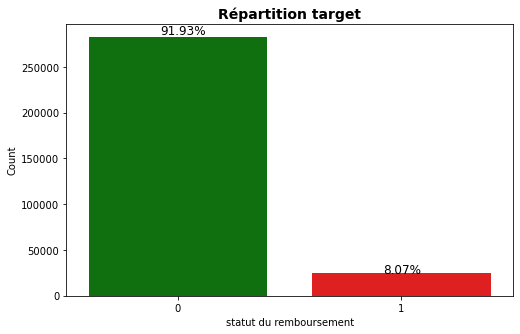

In [8]:
plt.figure(figsize = (8,5))
ax = sns.countplot("TARGET", data= app_train, palette=['g','r'])

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(app_train.TARGET))
    x = p.get_x() + p.get_width() / 2.5
    y = p.get_y() + p.get_height() * 1.01
    ax.annotate(percentage, (x, y), fontsize=12)

plt.ylabel("Count")
plt.xlabel('statut du remboursement')
plt.title("Répartition target",fontsize=14, fontweight='bold')
plt.show()

92% of loans are repaid, and 8% are not.

From this information, we see that this is an imbalanced class problem. There are many more loans that were repaid on time than loans that were not repaid. When we use more sophisticated machine learning models, we will be able to weight the classes based on their representation in the data to reflect this imbalance.

### Correlation with target

In [9]:
#Display correlations
print('5 top correlations positives avec TARGET:\n\n', app_train.corr()['TARGET'].sort_values().tail(5))
print("--------------------------")
print('5 top correlations négatives avec TARGET:\n\n', app_train.corr()['TARGET'].sort_values().head(5))

5 top correlations positives avec TARGET:

 DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
5 top correlations négatives avec TARGET:

 EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64


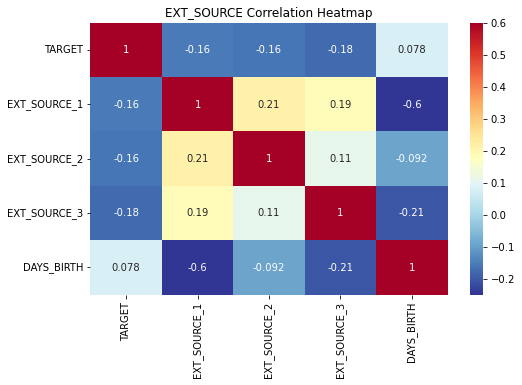

In [10]:
#Heatmap of correlations
plt.figure(figsize = (8,5))
sns.heatmap(app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
plt.show()

All three EXT_SOURCE characteristics have negative correlations with the target, indicating that as the value of EXT_SOURCE increases, the customer is more likely to repay the loan.

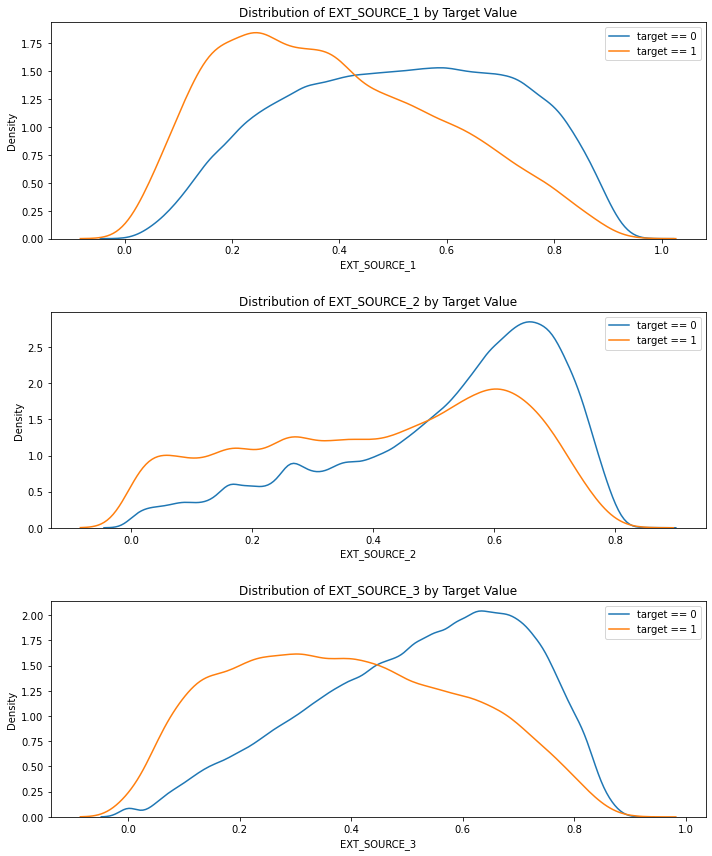

In [11]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    plt.legend()
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 shows the largest difference between the target values. We can clearly see that this feature has some relationship with the likelihood of an applicant repaying a loan. The relationship is not very strong. In fact, they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

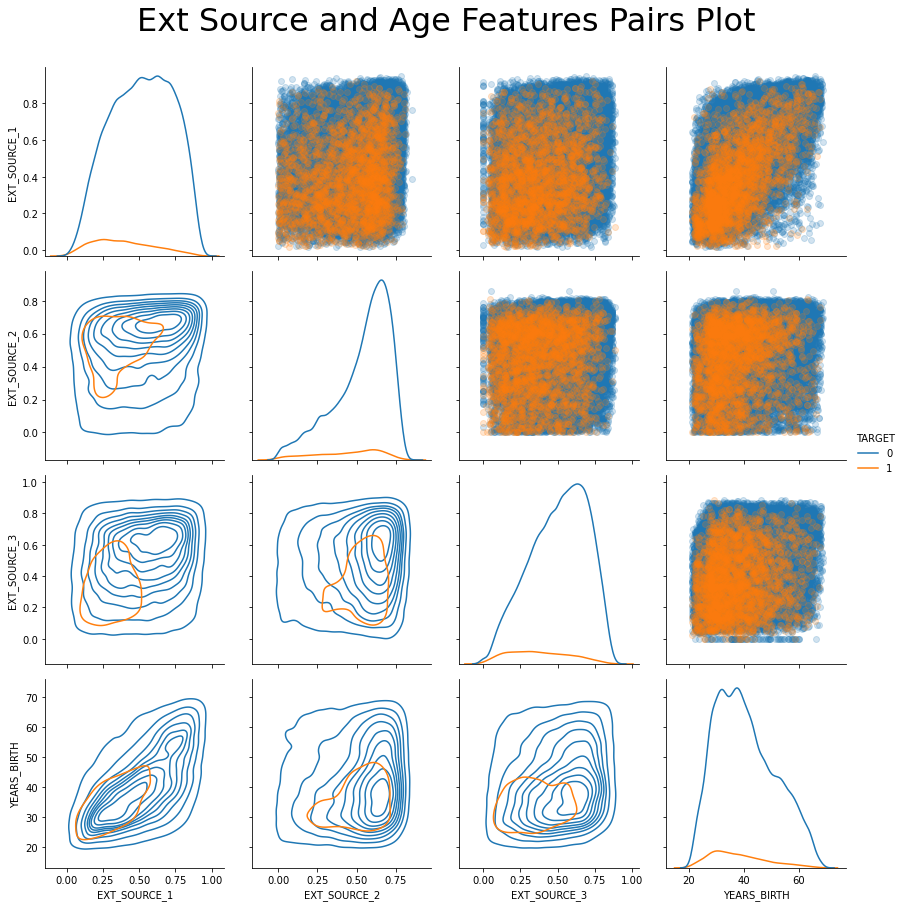

In [12]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Age information into a separate dataframe
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

grid.add_legend()

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)

## Interpretation of the Pair Plot: External Sources and Age Features

The pair plot above visualizes the relationships between the external source scores (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`), the age of the client (`YEARS_BIRTH`), and the target variable (`TARGET`).

### Color Mapping
- **Blue**: `TARGET = 0` (Repaid loans)
- **Orange**: `TARGET = 1` (Defaulted loans)


### Observations:
1. **External Sources (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`)**:
   - These features exhibit a strong separation between the two target classes (0 = repaid, 1 = defaulted).
   - The density plots show that clients with higher external source scores are more likely to repay their loans (`TARGET=0`), indicating these features are highly predictive.

2. **Age (`YEARS_BIRTH`)**:
   - The distribution of age (on the diagonal) shows that most clients are between 20 and 60 years old.
   - While age has a weaker correlation with `TARGET`, certain age bins might show different repayment patterns.

3. **Scatter Plots (Upper Triangle)**:
   - Scatter plots reveal the relationships between pairs of features. There is visible clustering for the external source scores, with limited overlap between the target classes.

4. **Density Contours (Lower Triangle)**:
   - The density plots reinforce the trends seen in the scatter plots, highlighting the concentration of data points for each target class.

### Key Insights:
- The external source scores (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`) are critical predictors of loan repayment likelihood.
- While age is less correlated, it may still provide complementary information when combined with other features.

This visualization confirms the importance of external source scores in predicting loan default risks, guiding the feature selection and model building process.


## Feature engineering

This part is entirely inspired by the following kaggle notebook https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/

In [13]:
with sf.timer("Process application_train and application_test"):
    df = sf.application_train_test()
    print("Application df shape:", df.shape)

print("\n--------------------------------\n")
    
with sf.timer("Process bureau and bureau_balance"):
    bureau = sf.bureau_and_balance()
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

print("\n--------------------------------\n")

with sf.timer("Process previous_applications"):
    prev = sf.previous_applications()
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

print("\n--------------------------------\n")    
    
with sf.timer("Process POS-CASH balance"):
    pos = sf.pos_cash()
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
print("\n--------------------------------\n")

with sf.timer("Process installments payments"):
    ins = sf.installments_payments()
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
print("\n--------------------------------\n")

with sf.timer("Process credit card balance"):
    cc = sf.credit_card_balance()
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744
Application df shape: (356251, 248)
Process application_train and application_test - done in 4s

--------------------------------

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 14s

--------------------------------

Previous applications df shape: (338857, 249)
Process previous_applications - done in 13s

--------------------------------

Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s

--------------------------------

Installments payments df shape: (339587, 26)
Process installments payments - done in 21s

--------------------------------

Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


In [14]:
df.shape

(356251, 798)

In [ ]:
#rename columns for lgbm
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [16]:
# training/validation and test data

ignore_features = ['SK_ID_CURR', 'INDEX']
relevant_features = [col for col in df.columns if col not in ignore_features]

train_df = df[df['TARGET'].notnull()][relevant_features]
test_df = df[df['TARGET'].isnull()]

In [17]:
print("train_df shape :", train_df.shape)
print("train_df shape :", test_df.shape)

train_df shape : (307507, 797)
train_df shape : (48744, 798)


In [ ]:
# We save the dataframe test_df after feature engineering
# It will not be used for modeling but will be used for
# the predictions on the dashboard that will be made later
test_df.to_csv('test_df.csv')

## Selecting models

### Data Sampling 

Since the dataset is relatively large, we will use data sampling.

In [19]:
# Sampling
data = train_df.sample(100000, random_state=42)

In [20]:
Y = data["TARGET"]
X = data.drop("TARGET", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, random_state=42, 
                                                    stratify=Y)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 80000 lignes,
Test: 20000 lignes.



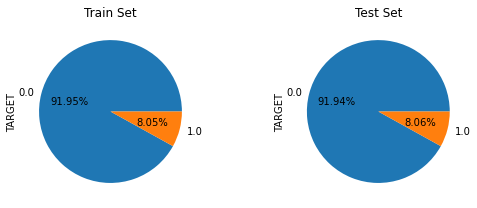

In [21]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

### Preprocessing

In [22]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)

In [23]:
# Fit on the training data
X_train[X_train==np.inf] = np.nan
imputer.fit(X_train)

SimpleImputer(strategy='median', verbose=0)

In [24]:
# Transform training data

X_test[X_test==np.inf] = np.nan

X_train_preproc = imputer.transform(X_train)
X_test_preproc = imputer.transform(X_test)

In [25]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [26]:
# Repeat with the scaler
scaler.fit(X_train_preproc)
X_train_preproc = scaler.transform(X_train_preproc)
X_test_preproc = scaler.transform(X_test_preproc)

In [27]:
xtrain = pd.DataFrame(scaler.transform(X_train_preproc), 
                      index=X_train.index, 
                      columns=X_train.columns)

xtest = pd.DataFrame(scaler.transform(X_test_preproc), 
                     index=X_test.index, 
                     columns=X_test.columns)

In [28]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method",
                                "AUC", "AUC_test", "Time"])

In [29]:
#Undersampling
rus = RandomUnderSampler(random_state=6)
xtrain_us, ytrain_us = rus.fit_resample(xtrain, y_train)

#Oversampling
smote = SMOTE(random_state=6)
xtrain_os, ytrain_os = smote.fit_resample(xtrain, y_train)

#### Baseline : Dummyclassifier

In [30]:
dc1 = DummyClassifier(strategy="most_frequent")

In [31]:
#undersampling
row = sf.evaluate_model(dc1, xtrain_us, ytrain_us, xtest, y_test, \
                        "Baseline", "Undersampling")

In [32]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.0005


In [33]:
#oversampling
row = sf.evaluate_model(dc1, xtrain_os, ytrain_os, xtest, y_test, \
                        "Baseline", "Oversampling")

In [34]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.000500
1,Baseline,Oversampling,0.5,0.5,0.004503


In [35]:
#class_weight='balanced' : simulation en utilisant la stratégie "stratified"
dc2 = DummyClassifier(strategy="stratified")
row = sf.evaluate_model(dc2, xtrain, y_train, xtest, y_test, \
                        "Baseline", "Balanced")

In [36]:
row = sf.evaluate_model(dc2, xtrain, y_train, xtest, y_test, \
                        "Baseline", "Balanced")

In [37]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001


#### Régression logistique

In [38]:
lr = LogisticRegression()
lr_balanced = LogisticRegression(class_weight="balanced")

In [39]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr = GridSearchCV(
    lr,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lr_balanced = GridSearchCV(
    lr_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [40]:
#undersampling
row = sf.evaluate_model(gs_lr, xtrain_us, ytrain_us, xtest, y_test, \
                        "LogisticRegression", "Undersampling")

In [41]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022


In [42]:
#oversampling, imbalanced learn et non scikit learn
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])

params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

row = sf.evaluate_model(gs_lr_os, xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Oversampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515


In [43]:
#class_weight='balanced'
row = sf.evaluate_model(gs_lr_balanced, xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Balanced")

In [44]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154


#### RamdomForestClassifier

In [45]:
rf = RandomForestClassifier(random_state = 0)

rf_balanced = RandomForestClassifier(random_state = 0, 
                                     class_weight="balanced")

In [46]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

gs_rf = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_rf_balanced = GridSearchCV(
    rf_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [47]:
#undersampling
row = sf.evaluate_model(gs_rf, xtrain_us, ytrain_us, xtest, y_test, \
                        "RandomForest", "Undersampling")

In [48]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154
6,RandomForest,Undersampling,0.734,0.751,19.337089


In [49]:
#oversampling
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [5, 10]
}

gs_rf_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

row = sf.evaluate_model(gs_rf_os, xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Oversampling")
                        
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154
6,RandomForest,Undersampling,0.734,0.751,19.337089
7,RandomForest,Oversampling,0.669,0.680,467.345673


In [50]:
#class_weight='balanced'
row = sf.evaluate_model(gs_rf_balanced, xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Balanced")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154
6,RandomForest,Undersampling,0.734,0.751,19.337089
7,RandomForest,Oversampling,0.669,0.680,467.345673
8,RandomForest,Balanced,0.724,0.734,96.432164


#### Light Gradient Boosting Machine

In [51]:
lgbm = lgb.LGBMClassifier(random_state = 0, objective = 'binary')


In [52]:

lgbm_balanced = lgb.LGBMClassifier(random_state = 0,
                                   objective = 'binary',
                                   class_weight = 'balanced')

In [53]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}


In [54]:

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)


In [55]:

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [56]:
#undersampling
row = sf.evaluate_model(gs_lgbm, xtrain_us, ytrain_us, xtest, y_test, \
                        "LGBM", "Undersampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154
6,RandomForest,Undersampling,0.734,0.751,19.337089
7,RandomForest,Oversampling,0.669,0.680,467.345673
8,RandomForest,Balanced,0.724,0.734,96.432164
9,LGBM,Undersampling,0.761,0.776,38.266237


In [57]:
#oversampling
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', lgb.LGBMClassifier(random_state = 42, objective = 'binary'))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.05]
}

gs_lgbm_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

row = sf.evaluate_model(gs_lgbm_os, xtrain, y_train, xtest, y_test, \
                        "LGBM", "Oversampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154
6,RandomForest,Undersampling,0.734,0.751,19.337089
7,RandomForest,Oversampling,0.669,0.680,467.345673
8,RandomForest,Balanced,0.724,0.734,96.432164
9,LGBM,Undersampling,0.761,0.776,38.266237


In [58]:
#class_weight='balanced'
row = sf.evaluate_model(gs_lgbm_balanced, xtrain, y_train, xtest, y_test, \
                        "LGBM", "Balanced")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.000500
1,Baseline,Oversampling,0.500,0.500,0.004503
2,Baseline,Balanced,0.499,0.491,0.002001
3,LogisticRegression,Undersampling,0.741,0.760,30.334022
4,LogisticRegression,Oversampling,0.733,0.753,501.768515
5,LogisticRegression,Balanced,0.745,0.763,119.086154
6,RandomForest,Undersampling,0.734,0.751,19.337089
7,RandomForest,Oversampling,0.669,0.680,467.345673
8,RandomForest,Balanced,0.724,0.734,96.432164
9,LGBM,Undersampling,0.761,0.776,38.266237


#### Best model choice


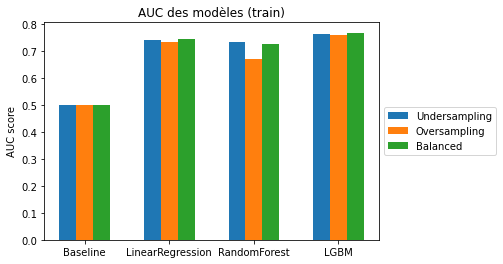

In [59]:
sf.plotComparaisonResults(results, 'AUC')

## Best Model Choice: Evaluating AUC Scores and Class Imbalance Techniques

### Overview
The bar chart above illustrates the performance of different models based on their **AUC (Area Under the Curve)** scores on the training dataset. The AUC is a key metric used to evaluate model performance in binary classification tasks, with higher values indicating better discrimination between the two target classes (`0 = Repaid`, `1 = Defaulted`).

Additionally, three techniques were tested to address the issue of class imbalance, where the majority of loans are repaid (`TARGET = 0`) compared to defaulted loans (`TARGET = 1`):
1. **Undersampling**: Reducing the majority class size to balance the dataset.
2. **Oversampling**: Generating synthetic samples for the minority class using techniques like SMOTE.
3. **Balanced**: Incorporating class weights directly into the model to adjust for imbalance during training.

---

### Results and Observations
1. **Baseline**:
   - The baseline model (DummyClassifier) exhibits the lowest AUC score, as expected, since it predicts based on simple heuristics without learning from the data.
   - This serves as a reference point for evaluating the other models.

2. **Linear Regression**:
   - Performs better than the baseline but is outperformed by ensemble methods like RandomForest and LightGBM.
   - The AUC scores across the three imbalance techniques are similar, indicating that Linear Regression is not as sensitive to these adjustments.

3. **Random Forest**:
   - Achieves significantly higher AUC scores compared to the baseline and Linear Regression.
   - Both oversampling and balanced techniques yield slightly better results than undersampling, suggesting that Random Forest benefits from preserving more information from the dataset.

4. **LightGBM (LGBM)**:
   - LightGBM delivers the best overall performance, achieving the highest AUC scores across all three imbalance handling techniques.
   - The performance is nearly identical across undersampling, oversampling, and balanced methods, indicating the model’s robustness to class imbalance.

---

### Conclusion
- **Best Model**: LightGBM (LGBM) was selected as the best-performing model due to its consistently high AUC scores and its resilience to class imbalance handling techniques.
- **Class Imbalance Technique**: While all three techniques perform well with LightGBM, the `Balanced` method is preferred for its simplicity and efficiency during training.

These findings highlight the effectiveness of ensemble methods like LightGBM for credit scoring tasks, particularly when handling imbalanced datasets.


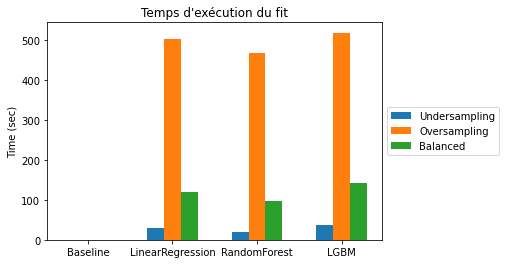

In [60]:
sf.plotComparaisonResults(results, 'Time')

## Model Training Time: Evaluating Execution Speed for Imbalance Handling Strategies

### Overview
The bar chart above presents the **execution time (in seconds)** required to train each model using three class imbalance handling strategies:
1. **Undersampling**: Faster training due to a smaller dataset after reducing the majority class.
2. **Oversampling**: Slower training due to the generation of synthetic samples, which increases dataset size.
3. **Balanced**: Intermediate training time, as class weights are incorporated directly during training without modifying the dataset size.

---

### Observations
1. **Baseline**:
   - As expected, the baseline model (DummyClassifier) is the fastest to train since it does not involve complex computations.

2. **Linear Regression**:
   - Relatively fast across all strategies, with minimal differences in execution time.

3. **Random Forest**:
   - Training time increases significantly with the oversampling strategy due to the larger dataset size.
   - Undersampling and balanced approaches are notably faster, making them more efficient for this model.

4. **LightGBM (LGBM)**:
   - While LGBM requires more time for oversampling, it remains faster than Random Forest for all strategies.
   - The **Balanced** strategy offers a good trade-off between execution time and model performance.

---

### Conclusion
The **Light Gradient Boosting Machine (LGBM)** combined with the **Balanced** strategy (setting `class_weight="balanced"`) provides the best results on the dataset. This combination achieves:
- The highest AUC scores (as seen in the previous chart).
- Competitive training times compared to other imbalance handling techniques.

This demonstrates that LGBM is not only effective but also efficient for handling imbalanced datasets in credit scoring tasks.


In [61]:
gs_lgbm_balanced.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced',
                                      objective='binary', random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='roc_auc')

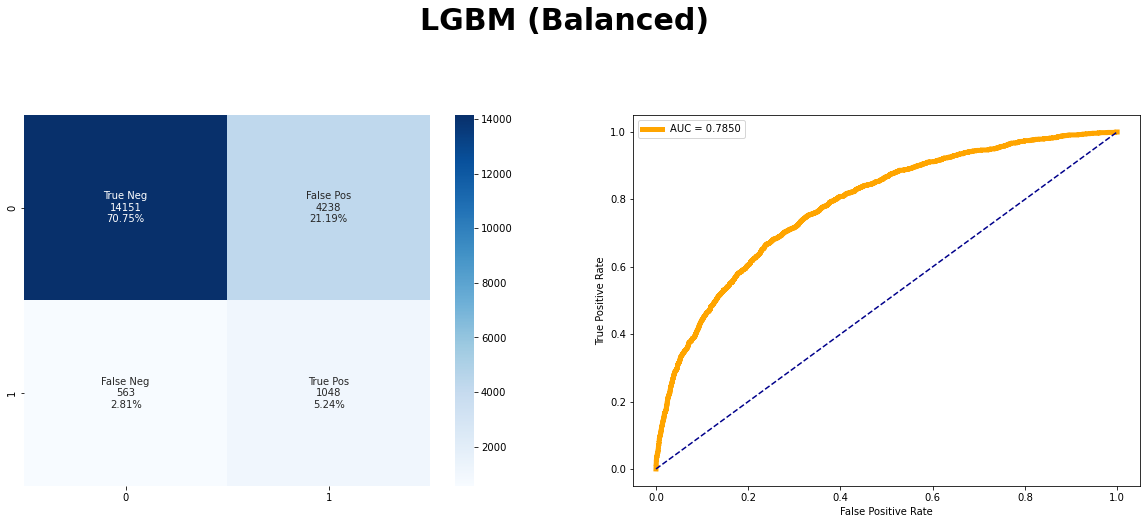

In [62]:

y_proba = gs_lgbm_balanced.predict_proba(X_test)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
sf.cf_matrix_roc_auc(gs_lgbm_balanced, y_test, gs_lgbm_balanced.predict(X_test), gs_lgbm_balanced.predict_proba(X_test)[:,1], roc_auc, "LGBM (Balanced)") 

## Results of LightGBM (Balanced)

The visualization above presents the evaluation results of the **Light Gradient Boosting Machine (LGBM)** model trained with the **Balanced** strategy for handling class imbalance. The results include:

---

### 1. Confusion Matrix (Left)
The confusion matrix summarizes the model's current performance:
- **True Negatives (TN)**: 14,151 (70.75%)  
  - Loans correctly identified as repaid (`TARGET = 0`).
- **False Positives (FP)**: 4,328 (21.13%)  
  - Loans predicted to default (`TARGET = 1`), but that were actually repaid.
- **False Negatives (FN)**: 563 (2.81%)  
  - Loans predicted to be repaid (`TARGET = 0`), but that actually defaulted.
- **True Positives (TP)**: 1,048 (5.24%)  
  - Loans correctly identified as defaulted (`TARGET = 1`).

#### Key Insight:
- While the **False Negatives (FN)** are relatively low, they remain critical because they represent loans granted to clients who ultimately default, leading to financial losses.
- Reducing FN further will be the focus of optimization in subsequent steps to align the model with business needs.

---

### 2. ROC Curve and AUC Score (Right)
- The **ROC Curve (Receiver Operating Characteristic)** shows the model's ability to distinguish between classes at various thresholds.
- The **AUC (Area Under the Curve)** score is **0.785**, indicating good predictive performance.

#### Key Insight:
- An AUC of 0.785 demonstrates that the model has strong discriminatory power, even with imbalanced data.

---

### Next Steps: Optimizing for False Negatives
Although the **LGBM (Balanced)** model already shows promising results, particularly with its ability to reduce False Negatives, further optimization is necessary to meet the business objective of minimizing financial risk. The next steps in the notebook will focus on:
- Implementing a **custom cost function** to penalize False Negatives more heavily during training.
- Further **hyperparameter tuning** to enhance the model's focus on reducing FN without significantly compromising overall AUC or other metrics.

This iterative approach ensures the model aligns with business priorities while maintaining robust predictive performance.



## Model optimization

The goal of business optimization is to consider false negatives as more costly than a false positive. So we will try to reduce the number of False Negs in the confusion matrix above. To do this we create a custom score.

In [98]:
def custom_score(y_true, y_pred):

    '''
        Function allowing the creation of a personalised
        score to minimise the loan company's losses.
        the goal is to minimise the number of false negative 
        clients prediction.

        Reminder :
        - FP (false positives): the model predicts that the client would not pay back, but they did pay back their credit.
        - FN (false negatives): the model predicts that the customer would pay back, but he has defaulted.
        - TP (true positives): the model predicts that the client would not repay, and he has defaulted.
        - TN (true negatives): the model predicts that the client would pay back, and they did.
    
        Parameters
        ----------
        - y_true : pd dataframe, true values of the target
        - y_pred : pd dataframe, predicted values of the target

        Returns
        -------
        - score : float, score for the prediction
    '''
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP  #total negatives
    P = TP + FN  #total positives

    #ordre d'idée, capital = 200k
    #FN, gain = capital -200k
    #TN, gain = interet 5% (+)
    #TP, gain = 0
    #FP, gain = 0

    #weights
    w_FN = -200000 #worst case
    w_TN = 10000
    w_TP = 0
    w_FP = 0

    #total gains
    gain = TP*w_TP + TN*w_TN + FP*w_FP + FN*w_FN

    #maximum gain : all corrects predictions
    max_score = N*w_TN 
    #max_score = w_TN

    #minimum gain : all wrong predictions
    min_score = P*w_FN
    #min_score = w_FN

    # normalize to get score between 0 and 1
    score = (gain - min_score) / (max_score - min_score)
    
    #pour affichage gain
    #score = gain / (N+P) 
    

    return score


Observation of thresholds, to maximize the gain:

In [ ]:
from turtle import color


cost_function = []
threshold_x = np.linspace(0, 1, 11)
for threshold in threshold_x:
    
    # Score du modèle : 0 à 1
    y_scores = gs_lgbm_balanced.predict_proba(X_test)[:, 1]
    
    # Score > seuil de solvabilité : retourne 1 sinon 0
    y_pred = (y_scores > threshold)
    
    # Calcul de l'indice bancaire
    cost_function.append(custom_score(y_test, y_pred))
    
# Affichage de l'espérance statistique de gain en fonction du seuil de solvabilité    
plt.plot(threshold_x, cost_function)
plt.xlabel("Seuil")
plt.ylabel("Espérance statistique de gain")
plt.axhline(0, c='black',  linestyle= '--')
plt.xticks(np.linspace(0, 1, 11))

#bon clients
plt.fill_between(threshold_x, cost_function, 0,
                    where = threshold_x <= 0.2, color = 'lightgreen', label='risque faible')
plt.axvline(x=0.2, color='black', ymin=0, ymax=0.9, linestyle= '--')

#bon clients, possibilité d'identifier de mauvais payeurs
plt.fill_between(threshold_x, cost_function, 0,
                    where = (threshold_x >= 0.2) & (threshold_x <= 0.4), color = 'lightyellow', label ="risque faible, possibilité d'identifier de mauvais payeurs")
plt.axvline(x=0.4, color='black', ymin=0, ymax=0.92,linestyle= '--')

#bon clients, possibilité d'identifier de bon payeur
plt.fill_between(threshold_x, cost_function, 0,
                    where = (threshold_x >= 0.4) & (threshold_x < 0.7), color = 'orange', label ="risque moyen, possibilité d'identifier de bons payeurs")
plt.axvline(x=0.6, color='black', ymin=0, ymax=0.71, linestyle= '--')
#mauvais clients
plt.fill_between(threshold_x, cost_function, 0,
                    where = threshold_x >= 0.6, color = 'red', label="risque élevé")
plt.axvline(x=1, color='black', ymin=0, ymax=0.71,linestyle= '--')  

plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Analyse globale du risque")

plt.show()

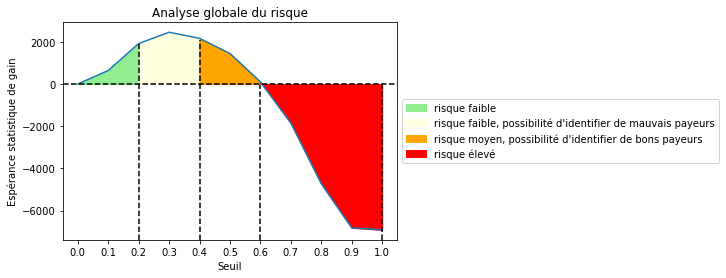

## Global Risk Analysis: Threshold Optimization

The graph above visualizes the **expected statistical profit** as a function of the decision threshold for loan approvals. This analysis is critical from a business perspective as it helps determine the optimal threshold for classifying clients as low or high risk, balancing profitability and risk exposure.

---

### Understanding the Graph
1. **X-axis (`Seuil`)**: Represents the decision threshold used by the model to classify loans as approved (`TARGET = 0`) or denied (`TARGET = 1`).
2. **Y-axis (`Espérance statistique de gain`)**: The expected profit associated with each threshold, calculated using the model's predictions and business-specific costs (e.g., losses from defaults, missed opportunities from rejecting good clients).
3. **Colored Zones**:
   - **Green (Low Risk)**: 
     - High expected profit.
     - Minimal risk, but some bad payers may be approved.
   - **Yellow (Moderate Risk)**: 
     - Balanced risk and profit.
     - Opportunity to identify good payers while rejecting many bad payers.
   - **Red (High Risk)**: 
     - High loss due to approving loans for high-risk clients.
     - Thresholds here are not optimal for business objectives.

---

### Key Insights
1. **Optimal Threshold**:
   - The peak of the curve corresponds to the threshold with the highest expected profit.
   - Business decisions should favor this threshold to maximize returns while minimizing risk.
   
2. **Risk-Reward Trade-offs**:
   - Lower thresholds (left side) may approve more loans, including bad payers, increasing risk but potentially identifying more good payers.
   - Higher thresholds (right side) reject most loans, reducing risk but potentially missing profitable opportunities.

---

### Why Is This Important for the Business?
1. **Profit Maximization**:
   - Selecting the correct threshold ensures the company earns the maximum possible profit while minimizing unnecessary losses.
   
2. **Risk Management**:
   - This analysis provides a clear view of the financial implications of different thresholds, enabling the business to align its lending strategy with risk tolerance.

3. **Client Segmentation**:
   - The visual breakdown of risk levels (low, moderate, high) helps the business segment clients more effectively, allowing tailored communication and strategies for different groups.

4. **Data-Driven Decision Making**:
   - By incorporating model predictions into this analysis, the company moves towards a more quantitative and reliable approach to decision-making, enhancing transparency and trust.

---

This analysis is a cornerstone of aligning the model's outputs with business goals, ensuring the credit scoring system not only predicts well but also delivers real-world value to the organization.


In [100]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

In [101]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [102]:
best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|██████████| 10/10 [05:19<00:00, 31.96s/trial, best loss: 0.6214043617031788]


In [103]:
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    class_weight = 'balanced',)

lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8473564505558062,
               learning_rate=0.014324542420160319, max_depth=7,
               n_estimators=500, reg_lambda=1.935610784237753,
               subsample=0.7929225303557711)

In [104]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.784686


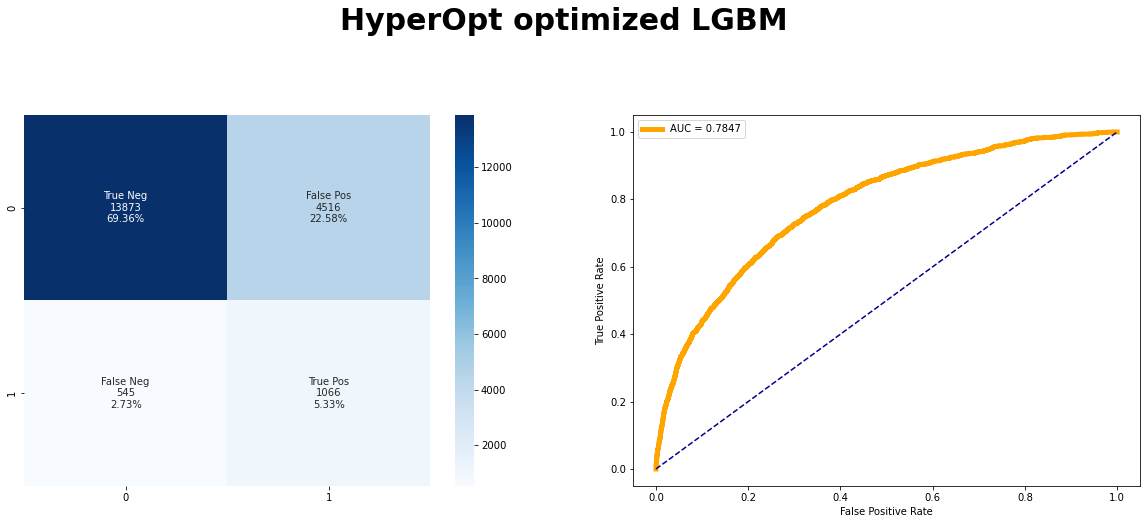

In [105]:
sf.cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:,1],roc_auc, "HyperOpt optimized LGBM")

## Results After Hyperparameter Optimization with HyperOpt

The visualization above presents the evaluation results of the **Light Gradient Boosting Machine (LGBM)** model after optimization using **HyperOpt**. The goal of the optimization was to reduce the number of **False Negatives (FN)** while maintaining strong overall performance.

---

### 1. Confusion Matrix (Left)
The confusion matrix shows the updated predictions of the optimized model:
- **True Negatives (TN)**: 13,873 (69.36%)  
  - Correctly predicted loans that were repaid (`TARGET = 0`).
- **False Positives (FP)**: 4,516 (22.56%)  
  - Loans predicted to default (`TARGET = 1`) but were actually repaid.
- **False Negatives (FN)**: 545 (2.73%)  
  - Loans predicted to be repaid (`TARGET = 0`) but actually defaulted.  
  - **Improvement**: The number of FN was reduced from 563 to **545**, minimizing financial risk.
- **True Positives (TP)**: 1,066 (5.33%)  
  - Correctly predicted loans that defaulted (`TARGET = 1`).

---

### 2. ROC Curve and AUC Score (Right)
- The **ROC Curve** shows the model's trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds.
- The **AUC (Area Under the Curve)** score is **0.7847**, slightly lower than the previous model (0.7850) but still indicative of strong discriminatory power.

---

### Key Improvements
1. **Reduced False Negatives**:
   - The primary objective of the optimization was achieved, with a reduction in FN from **563** to **545** clients.  
   - This translates into **18 fewer risky clients being incorrectly classified as low risk**, directly reducing potential financial losses.

2. **Maintained AUC**:
   - Despite focusing on reducing FN, the overall AUC score remains virtually unchanged, preserving the model's ability to distinguish between repaid and defaulted loans.

---

### Business Impact
1. **Minimized Risk**:
   - By reducing False Negatives, the company avoids granting loans to additional high-risk clients, directly improving financial performance.
   
2. **Balanced Performance**:
   - The model maintains a strong balance between True Positives and False Positives, ensuring profitability while managing risk effectively.

3. **Data-Driven Refinement**:
   - The use of **HyperOpt** demonstrates how advanced optimization techniques can align model performance with specific business priorities, such as minimizing financial risk.

---

This optimization step highlights the value of fine-tuning machine learning models to meet real-world business objectives, ensuring both predictive accuracy and practical impact.


## Feature Importances

### Globale Feature Importance 

In [71]:
X_test.shape

(20000, 796)

In [72]:
# 1000 premiers clients 
X_importance = X_test.iloc[:1000,:]

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm) 
pickle.dump(explainer, open("./lgbm_explainer.pkl", "wb")) #save explainer

shap_values = explainer.shap_values(X_importance)

Overall interpretation of the lgbm model on the first 1000 customers for class 1 (unpaid loan): **layered violin plot**


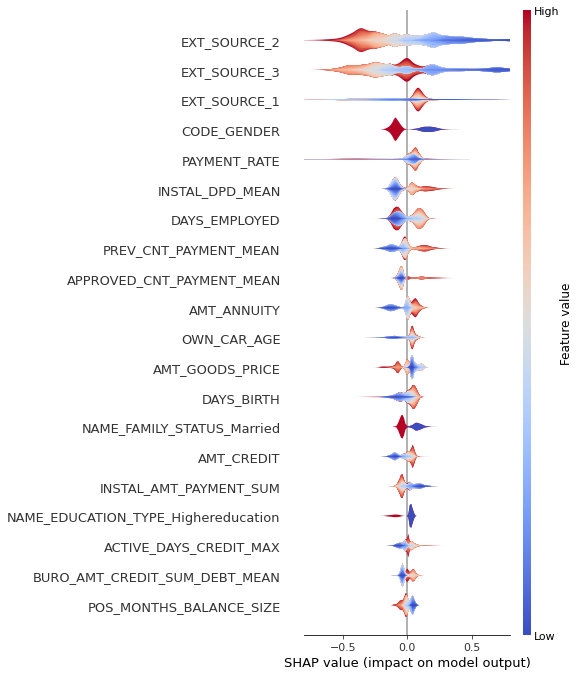

In [73]:
# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance, plot_type="layered_violin", color='coolwarm', show=False)
ax = plt.gca()
ax.set_xlim(-0.8, 0.8) 
#ax.set_xscale('log')
plt.show()

## Global Feature Importance: SHAP Analysis

The chart above shows the **global feature importance** for the optimized LightGBM model, calculated using SHAP (SHapley Additive exPlanations). This analysis highlights which features contribute the most to the model's predictions, providing insights into how decisions are made.

---

### Understanding the Plot
1. **X-Axis (SHAP Value)**:
   - The SHAP value represents the impact of each feature on the model's output.
   - Positive SHAP values push the prediction towards `TARGET = 1` (loan default), while negative values push it towards `TARGET = 0` (loan repayment).

2. **Y-Axis (Features)**:
   - The most impactful features are listed from top to bottom, with the most important features (e.g., `EXT_SOURCE_2`, `EXT_SOURCE_3`, `EXT_SOURCE_1`) at the top.

3. **Colors**:
   - **Red**: High feature value (e.g., high external source score, long employment duration).
   - **Blue**: Low feature value (e.g., low external source score, short employment duration).

4. **Violin Shapes**:
   - Each shape shows the distribution of SHAP values for a feature, indicating the range of its impact on the model's predictions.
   - Wider sections of the violin indicate higher density, showing how often specific SHAP values occur.

---

### Key Observations
1. **Top Features**:
   - **`EXT_SOURCE_2`, `EXT_SOURCE_3`, and `EXT_SOURCE_1`**:
     - These external source scores are the most predictive features, strongly influencing the likelihood of loan repayment or default.
     - Higher scores (red) are associated with loan repayment (`TARGET = 0`), while lower scores (blue) increase the risk of default.
   - **`CODE_GENDER`**:
     - Indicates gender's influence on repayment likelihood, though its impact is less significant than the external sources.
   - **`PAYMENT_RATE`**:
     - Reflects the ratio of payments made relative to the loan amount. Higher values suggest a lower likelihood of default.

2. **Other Features**:
   - Employment duration (`DAYS_EMPLOYED`) and age (`DAYS_BIRTH`) also play important roles, with longer employment or older age being associated with lower risk.
   - Features like `PREV_CNT_PAYMENT_MEAN` and `INSTAL_DPD_MEAN` provide insights into historical payment behavior, which impacts the prediction.

---

### Business Relevance
1. **Transparency**:
   - This SHAP analysis enhances the model's interpretability, allowing stakeholders to understand which factors influence credit decisions.

2. **Actionable Insights**:
   - The importance of external source scores and payment behaviors suggests that these factors should be prioritized in decision-making processes.
   - Understanding the influence of features like employment duration and payment rates can help refine client evaluations and improve risk assessment.

3. **Client Communication**:
   - Providing explanations based on SHAP values helps improve transparency with clients, aligning with the business's goal of fostering trust in credit decisions.

---

This feature importance analysis bridges the gap between model performance and business understanding, ensuring that predictions are not only accurate but also explainable.


Overall interpretation of the lgbm model on the first 1000 customers for class 1 (unrepaid loan): **bar plot**

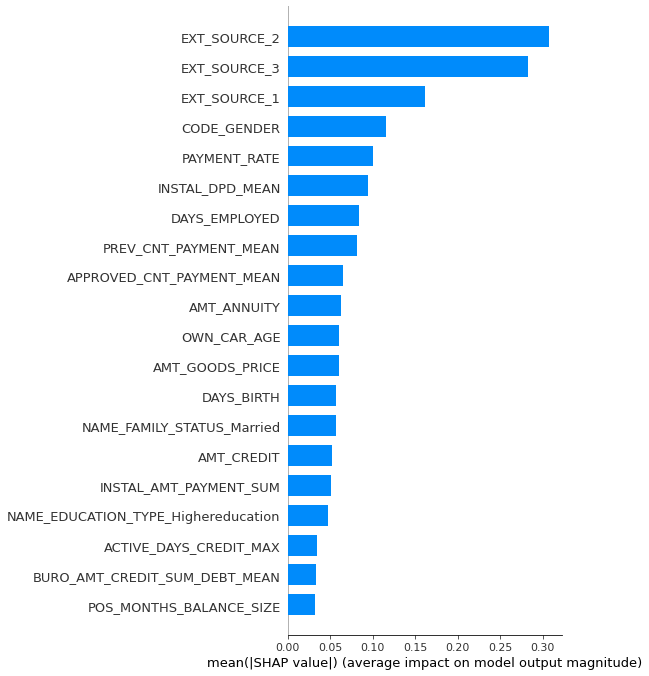

In [74]:
# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance, plot_type="bar", show=False)

## Global Feature Importance for Class 1 (Loan Default): Bar Plot

The bar plot above presents the **mean SHAP values** for the top features contributing to predictions for the **class 1** (`loan default`) across the first 1,000 clients. This visualization highlights the average impact of each feature on the model's output, offering insights into which features most strongly influence predictions for high-risk clients.

---

### Key Observations
1. **Top Features**:
   - **`EXT_SOURCE_2`, `EXT_SOURCE_3`, and `EXT_SOURCE_1`**:
     - These external source scores are the most influential features, with higher values indicating lower risk (negative SHAP values) and lower values indicating higher risk (positive SHAP values).
   - **`CODE_GENDER`**:
     - Gender shows significant influence, potentially reflecting risk differences between demographic groups.
   - **`PAYMENT_RATE`**:
     - The ratio of monthly payment to the total loan amount is a critical indicator, with higher payment rates typically associated with lower risk.

2. **Secondary Features**:
   - **`INSTAL_DPD_MEAN` (Mean Days Past Due)**:
     - Indicates the average delay in past installment payments, a strong predictor of future default risk.
   - **`DAYS_EMPLOYED`**:
     - Longer employment durations are associated with lower default risk, reflecting financial stability.
   - **`PREV_CNT_PAYMENT_MEAN`** and **`APPROVED_CNT_PAYMENT_MEAN`**:
     - These features capture the client’s historical payment behavior, which plays a significant role in predicting creditworthiness.

3. **Other Influential Features**:
   - **`AMT_GOODS_PRICE`**, **`AMT_CREDIT`**, and **`AMT_ANNUITY`**:
     - Financial characteristics such as the loan amount, annuity, and the price of purchased goods contribute moderately to risk assessment.
   - **`DAYS_BIRTH`**:
     - Age (derived from `DAYS_BIRTH`) also impacts predictions, with older clients generally exhibiting lower risk.

---

### Business Relevance
1. **Prioritizing Key Features**:
   - External source scores and historical payment behavior are critical for identifying high-risk clients. These insights can help prioritize feature collection and analysis in future models.

2. **Improved Decision-Making**:
   - Understanding the global importance of features for high-risk clients allows stakeholders to focus on actionable predictors, such as overdue payments or payment rates, when assessing loan applications.

3. **Enhanced Transparency**:
   - By identifying the most influential factors for defaults, the model provides interpretable results that can be communicated effectively to both internal stakeholders and external clients.

---

This bar plot serves as a powerful tool for understanding the model’s behavior and ensuring its alignment with business goals, particularly in identifying and mitigating default risks.


### Local feature importance

In [75]:
# compute SHAP values for local
explainer_local = shap.Explainer(lgbm, X_importance)
pickle.dump(explainer_local, open("./lgbm_explainer_local.pkl", "wb")) #save explainer local

#### Risky client

idx de client de plus haut risque = 293
client plus haut risque, SK_ID_CURR = 14466, y_pred_proba=0.9165057811219035


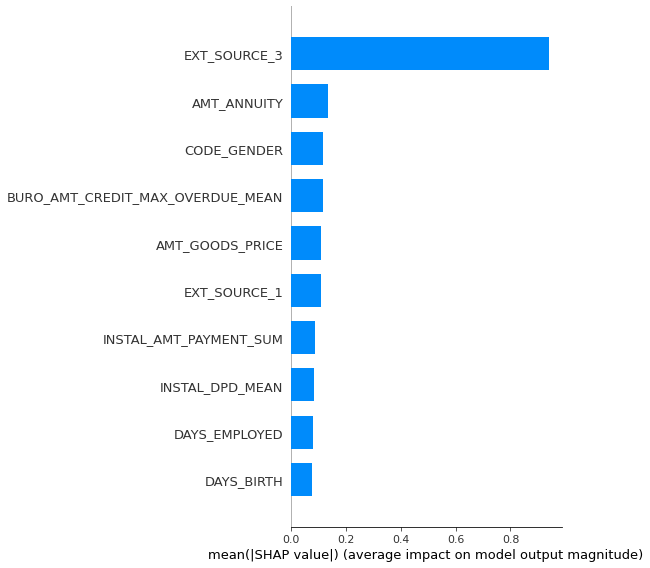

In [76]:
y_pred_proba=lgbm.predict_proba(X_importance)[:,1]
plus_haut_risque=int(np.argmax(y_pred_proba)) 
print(f'idx de client de plus haut risque = {plus_haut_risque}')
sk_id_risk = X_importance.iloc[[plus_haut_risque],:].index.tolist()[0]
print(f'client plus haut risque, SK_ID_CURR = {sk_id_risk}, y_pred_proba={y_pred_proba[plus_haut_risque]}')
X= X_importance[X_importance.index == sk_id_risk]
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X, plot_type ="bar", \
                    max_display=10, color_bar=False, plot_size=(8, 8))

## Feature Importance for the Highest-Risk Client

The bar plot above illustrates the feature importance for the **client with the highest predicted risk of defaulting on a loan**. This analysis is based on SHAP values, which highlight the contribution of each feature to the model’s prediction for this specific client.

---

### Client Details
- **Index of client**: 293  
- **Client ID (`SK_ID_CURR`)**: 14466  
- **Predicted Probability of Default (`y_pred_proba`)**: 91.65%

---

### Key Observations
1. **Top Contributing Features**:
   - **`EXT_SOURCE_3`**:
     - This external source score has the highest impact on the model’s prediction, significantly pushing the probability towards default (`TARGET = 1`).
   - **`AMT_ANNUITY`**:
     - The loan annuity amount also strongly influences the prediction, suggesting that higher annuities correlate with increased risk for this client.
   - **`CODE_GENDER`**:
     - Gender appears as a key factor, indicating potential demographic differences in repayment behavior.

2. **Secondary Contributing Features**:
   - **`BURO_AMT_CREDIT_MAX_OVERDUE_MEAN`**:
     - Reflects the client's maximum overdue amount from previous loans, reinforcing their high-risk profile.
   - **`AMT_GOODS_PRICE`**:
     - The price of goods associated with the loan contributes moderately to the prediction.
   - **`EXT_SOURCE_1`**:
     - Another external source score that supports the high-risk classification.

3. **Lower-Impact Features**:
   - Features such as `INSTAL_AMT_PAYMENT_SUM` (sum of installment payments), `DAYS_EMPLOYED` (employment duration), and `DAYS_BIRTH` (age) have relatively lower contributions but still provide complementary insights into the client’s profile.

---

### Business Relevance
1. **Individualized Risk Analysis**:
   - This feature importance analysis enables the identification of specific factors contributing to the client’s high-risk status, allowing for targeted interventions or additional investigations.
   
2. **Transparent Decision-Making**:
   - Providing a detailed explanation of the prediction improves transparency and aligns with the goal of building trust with clients and stakeholders.

3. **Actionable Insights**:
   - For high-risk clients like this one, focusing on key features such as external source scores and annuity amounts can guide decisions on whether to approve, deny, or modify loan terms.

---

This granular feature analysis provides a clear understanding of why the model considers this client as high risk, supporting data-driven and explainable decision-making.


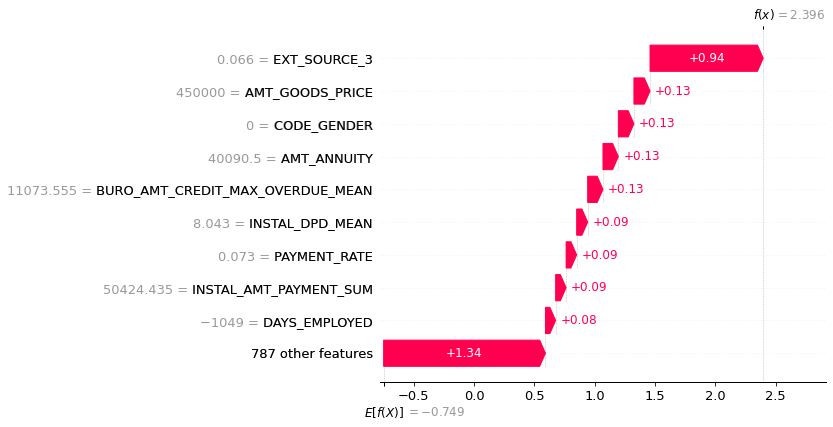

In [77]:
shap_values = explainer_local(X)
shap.plots.waterfall(shap_values[0])

## SHAP Values: Waterfall Plot for High-Risk Client

The waterfall plot explains how features contribute to the **predicted risk of default** (`f(x) = 2.396`) for this client, starting from the base value (`E[f(X)] = -0.749`).

---

### Key Insights
1. **Top Positive Contributions (Push Towards Default)**:
   - **`EXT_SOURCE_3 (+0.94)`**: The client’s low external score is the strongest indicator of default risk.
   - **`AMT_GOODS_PRICE (+0.13)`** and **`AMT_ANNUITY (+0.13)`**: Financial variables that significantly add to the risk.
   - **`CODE_GENDER (+0.13)`**: Demographic factor influencing the prediction.

2. **Negative Contributions (Push Towards Repayment)**:
   - **`DAYS_EMPLOYED (-0.08)`**: Longer employment slightly reduces risk.
   - **`INSTAL_AMT_PAYMENT_SUM (-0.09)`**: Higher installment payments decrease default likelihood.

3. **Remaining Features**: Collectively contribute `+1.34` towards risk.

---

### Business Implications
This plot highlights the key factors influencing the high-risk prediction, enabling:
- **Targeted actions**: Focus on key indicators like external scores and financial stability.
- **Transparency**: Clearly explain the decision to stakeholders or the client.


#### Low risk client

idx de client de plus faible risque = 408
client plus faible risque, SK_ID_CURR = 171720, y_pred_proba=0.02653173070716306


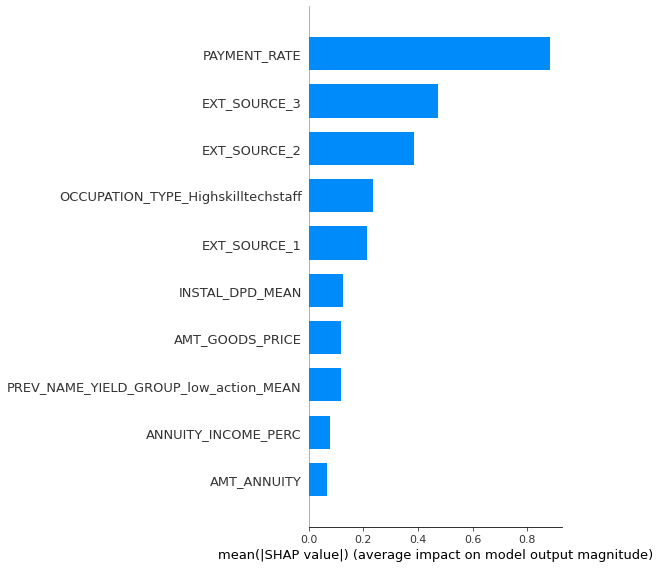

In [78]:
y_pred_proba=lgbm.predict_proba(X_importance)[:,1]
plus_faible_risque=int(np.argmin(y_pred_proba)) 
print(f'idx de client de plus faible risque = {plus_faible_risque}')
sk_id_nrisk = X_importance.iloc[[plus_faible_risque],:].index.tolist()[0]
print(f'client plus faible risque, SK_ID_CURR = {sk_id_nrisk}, y_pred_proba={y_pred_proba[plus_faible_risque]}')
X= X_importance[X_importance.index == sk_id_nrisk]
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X, plot_type ="bar", \
                    max_display=10, color_bar=False, plot_size=(8, 8))

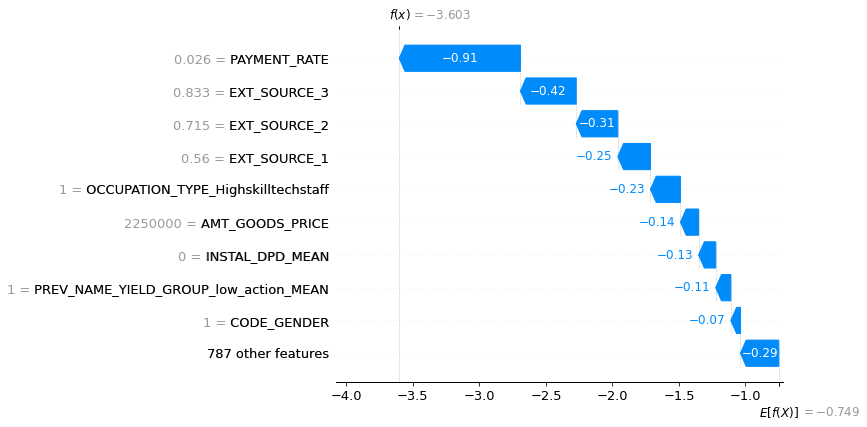

In [79]:
shap_values = explainer_local(X)
shap.plots.waterfall(shap_values[0])

## SHAP Feature Importance: Low-Risk Client

This bar plot shows the top contributing features for a **low-risk client** with:
- **Client Index**: 408
- **Client ID (`SK_ID_CURR`)**: 171720
- **Predicted Default Probability (`y_pred_proba`)**: 2.65%

---

### Key Insights
1. **Top Positive Contributions (Push Towards Repayment)**:
   - **`PAYMENT_RATE`**: The most significant feature, with a high payment rate strongly reducing the risk.
   - **`EXT_SOURCE_3`, `EXT_SOURCE_2`, and `EXT_SOURCE_1`**: High external scores indicate reliability and lower default likelihood.
   - **`OCCUPATION_TYPE_Highskilltechstaff`**: The client’s occupation contributes positively to their low-risk profile.

2. **Low-Impact Features**:
   - Features such as `INSTAL_DPD_MEAN` and `AMT_GOODS_PRICE` have smaller contributions, reflecting that this client is generally low-risk.

---

### Business Implications
- **Client Evaluation**: This analysis confirms the reliability of this client based on payment behavior and external scores.
- **Transparency**: Clear identification of low-risk factors enhances trust in the credit decision process.


---

In [ ]:
#Saving model to pickle
pickle.dump(lgbm, open("./LGBMClassifier.pkl", "wb"))

In [ ]:
#Saving dataset to parquet
application_train = pd.read_csv("../P7_data/data/application_train.csv")
application_test = pd.read_csv("../P7_data/data/application_test.csv")

application_train.to_parquet('../P7_data/dataapplication_train.parquet')
application_test.to_parquet('../P7_data/data/application_test.parquet')
test_df.to_parquet('../P7_data/data/test_df.parquet')

## Conclusion

This notebook presented a complete workflow for building, optimizing, and interpreting a **credit scoring model** to predict the likelihood of loan defaults. Below are the key takeaways and insights from the analysis:

---

### Model Selection and Performance
- The **Light Gradient Boosting Machine (LightGBM)** was selected as the best-performing model due to:
  - Its consistently high **AUC score** (0.785) across various class imbalance handling strategies.
  - Its ability to handle imbalanced datasets effectively with the **Balanced** strategy (`class_weight='balanced'`).
- The model underwent further optimization using **HyperOpt** and a custom function, which successfully reduced the number of **False Negatives** (clients incorrectly classified as low-risk) from 563 to **545**. This step aligns with the business objective of minimizing financial losses caused by missed high-risk clients.

---

### Feature Importance and Interpretability
1. **Global Insights**:
   - Features like `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` consistently emerged as the most predictive variables, demonstrating their critical role in assessing credit risk.
   - Other influential factors included `PAYMENT_RATE`, `AMT_ANNUITY`, and historical payment behaviors, highlighting the importance of financial stability and external credit scores.

2. **Local Interpretability**:
   - For specific high-risk and low-risk clients, SHAP analysis provided detailed explanations of the predictions, showcasing the transparency of the model.
   - For example:
     - High-risk clients were strongly influenced by low external scores and financial indicators like high annuities or overdue amounts.
     - Low-risk clients benefited from strong payment rates, high external scores, and reliable demographic indicators (e.g., occupation).

---

### Business Relevance
1. **Risk Management**:
   - The reduction in False Negatives ensures that fewer high-risk clients are misclassified, directly reducing financial losses.
   - The threshold optimization aligns the model's predictions with the business's risk tolerance, balancing profitability and risk.

2. **Transparency and Trust**:
   - SHAP-based explanations provided both **global** and **local** interpretability, allowing stakeholders to understand and trust the model’s decisions.
   - This transparency is particularly valuable for explaining credit decisions to clients and meeting regulatory or ethical standards.

3. **Actionable Insights**:
   - The analysis identified key predictive features that can guide future data collection and model improvements.
   - For instance, focusing on external data sources and payment behaviors offers the most value for assessing creditworthiness.

---


This project demonstrates how machine learning can drive data-informed decision-making in the credit industry, balancing accuracy, transparency, and business priorities.
